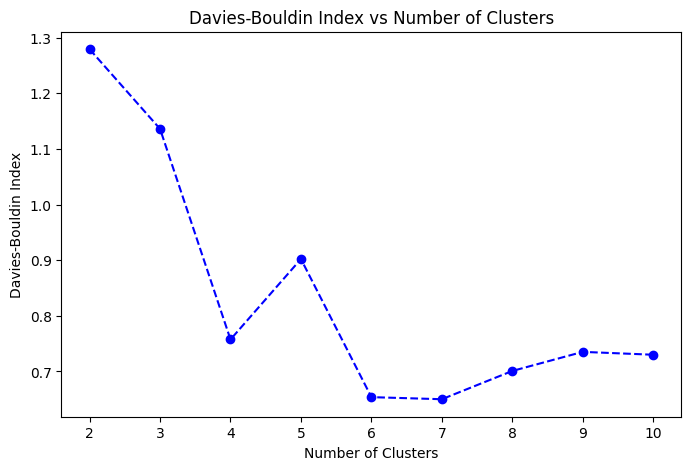

Optimal number of clusters: 7


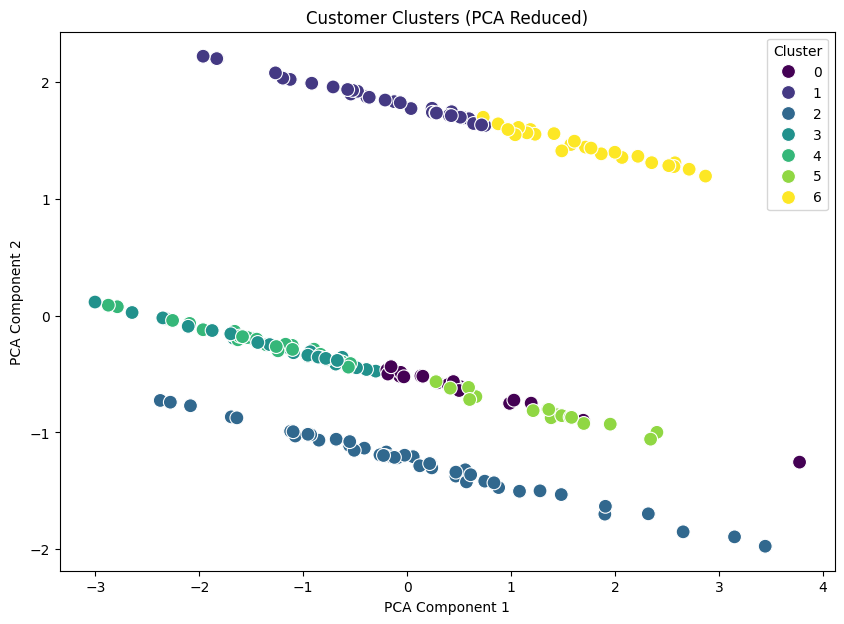

Davies-Bouldin Index for optimal clustering: 0.6499654265325037
Clustering results saved as 'FirstName_LastName_Clustering.csv'


In [14]:
# Required Libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

# Merge and prepare the data
# Aggregate transaction data
customer_agg = transactions.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalSpending=('TotalValue', 'sum')
).reset_index()

# Add region data
customer_data = customers.merge(customer_agg, on='CustomerID', how='left')

# Fill missing values (if any customers have no transactions)
customer_data['TotalTransactions'] = customer_data['TotalTransactions'].fillna(0)
customer_data['TotalSpending'] = customer_data['TotalSpending'].fillna(0)

# One-hot encode regions
customer_data = pd.get_dummies(customer_data, columns=['Region'], prefix='Region')

# Feature Scaling
scaler = StandardScaler()
features = scaler.fit_transform(customer_data.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

# Optimize number of clusters using Davies-Bouldin Index
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features)
    db_index = davies_bouldin_score(features, clusters)
    db_scores.append(db_index)

# Plot Davies-Bouldin scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o', linestyle='--', color='b')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Select the optimal number of clusters (lowest DB Index)
optimal_k = k_values[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_k}")

# Apply KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(features)

# Visualize Clusters (using PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_features[:, 0], y=pca_features[:, 1],
    hue=customer_data['Cluster'], palette='viridis', s=100
)
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Calculate Clustering Metrics
db_index = davies_bouldin_score(features, customer_data['Cluster'])
print(f"Davies-Bouldin Index for optimal clustering: {db_index}")

# Save results
customer_data.to_csv('FirstName_LastName_Clustering.csv', index=False)
print("Clustering results saved as 'FirstName_LastName_Clustering.csv'")
